# Project Summary
## Introduction
The idea of this project is to understand and implement different reinforcement learning algorithms and compare their performance. Initially, we start with the following four algorithms:
1. **Policy-Gradient:** Current states are the input, categorical actions the output. During training the targets are given as the action chosen, multiplied by $\pm 1$ depending on the reward. This works due to the structure of the softmax activation function and  categorical-crossentropy loss function.
2. **Deep-Q-Learner:** The inputs are given as the current state & and a candidate action. The output is the so-called Q-value — an estimate of the quality of an action. For action-selection we choose the action with the highest Q-value. The targets during training are formed by using the algorithm‘s *Bellman eq.*: $$Q(s_t, a_t) =r_t + \gamma \cdot \mathrm{max}_a Q(s_{t+1}, a_{t+1})$$ where we denote by $\gamma$ the so called *discount factor* which controls to which the model attends to long term behaviour.
3. **Deep-Q-Learner with Target Network:** This is an improved version of the former algorithm in which we build the targets during learning from a second so-called *target network*. This network is not trained, but instead we copy the *training network‘s* weights $\theta_\mathrm{train}$ every $d$ episodes using $$\theta_{\mathrm{target}} \leftarrow \tau \cdot \theta_{\mathrm{train}} + (1 - \tau) \cdot \theta_{\mathrm{target}}$$ for some $\tau \in [0,1]$. The intuition is, that we make convergence more stable by keeping the training targets more stable.
4. **Double-Q-Learner:** Once again this is an iteration on the former two algorithms. The difference is that we use a modified Bellman equation $$Q_{\mathrm{train}}(s_t, a_t)  = r_t + \gamma \cdot Q_{\mathrm{target}} \left( s_{t+1}, \mathrm{argmax}_a Q_{\mathrm{train}}(s_{t+1}, a_{t+1}) \right)$$ in which we have split the action-selection (done by the training network) from the action-evaluation (done by the target network). The idea behind this is to mitigate the overestimation problem of the Q-function during training (see [*van Hasselt, et al. (2015)*](https://arxiv.org/abs/1509.06461) for details).

Since the focus of this project is on learning and model-comparison, we start with a very simple environment from the [OpenAI-Gym, called CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/). However, all of the code in this repository has been kept completely generic to be able to employ our algorithms on  different environments later on. For now, we want to be able to stick to small networks and make sure all the algorithms work as expected and be able to compare the different models quickly.

Before we get to the code, please use the following two cells to install the required packages and to import the necessary modules, if you want to run the later cells.

In [ ]:
!pip install gymnasium matplotlib numpy pandas plotly scipy tensorflow

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import pandas as pd
import pickle
import plotly.express as px
from agents import DoubleQLearner, ModelHyperParams, PolicyGradient, QLearner, QLearnerWithTargetNetwork, RandomAgent
from environment_handler import CartPoleHandler
from scripts import parameter_scan, train, TrainingHyperParams

As an example on how to use this code base to train our version of the Q-Learner on this particular problem we could run the following code (we have put in unrealistically low training data, so it doesn't run for a long time - but it won't converge like this):

In [7]:
model_params = ModelHyperParams(
    initial_epsilon=0.5,
    epsilon_decay_constant=0.7,
    gamma=0.1,
    no_hidden_layers=2,
    units_per_hidden_layer=12,
    kernel_initializer="he_uniform"
)
training_params = TrainingHyperParams(
    batch_size=20,
    epochs=1,
    steps_per_epoch=20,
    max_buffer_size=20
)

env_handler = CartPoleHandler()
agent = QLearner(env_handler, model_params)

result = train(env_handler, agent, training_params)

1/1 [==============================] - 1s 623ms/step - loss: 0.1249
Current Benchmark Result:  11.0 Previously:  None . Reinitializing...
Finished training loop. Agent did not converge.


Of course getting the model to converge depends very strongly on the hyperparameters chosen. This means we need to do some hyperparameter tuning before we can get to comparing the different algorithms.

## Hyperparameter Tuning
In principle the different algorithms depend on multiple hyperparameters which a priori cannot be assumed to be independent or optimized separately. Moreover, training neural networks is not deterministic and reinforcement learning suffers even more from this problem. This means that we will have to run multiple training cycles for each hyperparameter configuration to actually have statistically significant differences. In the setting presented here we have mainly the following hyperparameters to adjust:
* **Batch size:** Due to the very noisy data in reinforcement learning this becomes even more important
* **Discount Factor $\gamma$:** For the Q-Learner algorithms this governs how much we take long-term behaviour into account (see Bellman eq.).
* **Proportion of random actions $\varepsilon$ & its decay:** All algorithms use an $\varepsilon$-greedy policy to balance exploration & exploitation.
* **Model architecture:** Number of layers and nodes per layer.
* **Optimiser & Learning Rate:** Do we choose adaptive optimisers such as *Adam* / *RMSProp* or static ones such as *SGD*. How does the *learning rate* affect convergence?
* **Weight initialiser:** Since convergence has been shown to be somewhat flaky, clearly the random initialisation of the weights matters and this is another parameter to explore.
* **Regularisation:** Since we might choose larger networks due to initialisation issues, we can consider counter-balancing this with regularisation (e.g. *L1*).
* **Target network update frequency $d$ and proportion $\tau$:** For those Q-Learners with target networks these two variables control how fast and abrupt we update the target network.

Clearly, it is unfeasable even for this simple environment to scan the whole hyper-parameter space. So what can we do? We can argue that some of the parameters are in good approximation independent of the others and in fact independent of the models as they are for the most part defined by the problem:
1. The optimal batch size is determined by how much data we need in a given batch to mitigate for the noise. While this will of course depend on the randomness of the policy and thereby the model its parameters, we suspect that these are second order effects and that the largest contribution is defined by the problem itself. This allows us to find the optimal batch size without varying the other variables.
2. The discount factor $\gamma$ encodes how long range behaviour affects the current reward and is therefore also mostly determined by the environment rather than the model.
3. The remaining parameters are tougher to separate as they are interlinked.

So how can we find e.g. the best batch size? We can run multiple training cycles for each batch size and count how many times the model converged to a successful state (here this is defined to be able to control the cart-pole for 200 subsequent actions before it falls). After each new training cycle we can compute a $p$-value of how likely the results come from different distributions using a *permutation test*. Once we have established the best batch size with a *p*-value of 95%, we assume this to be the best parameter setting. For demonstration purposes, we present here the code to run a parameter search, but set the training data to unrealistically low values again, so it does not run for a long time. (See `find_best_batch_size.py` for a real example).

In [8]:
def get_training_params(batch_size: int) -> TrainingHyperParams:
    return TrainingHyperParams(
        batch_size=batch_size,
        epochs=1,
        steps_per_epoch=32,
        max_buffer_size=64
    )


make_agent_fct=lambda e, p: PolicyGradient(e, p, verbose=0)
make_env_handler_fct=lambda: CartPoleHandler()
model_params = ModelHyperParams(
    initial_epsilon=0.5,
    epsilon_decay_constant=0.7,
    no_hidden_layers=1,
    units_per_hidden_layer=4,
    optimizer="adam",
    kernel_initializer="he_uniform"
)
batch_sizes = [16, 32]
hyper_param_dict = {b: (get_training_params(b), model_params) for b in batch_sizes}

parameter_scan(hyper_param_dict, make_agent_fct, make_env_handler_fct, verbose=0,
               max_runs=2, runs_per_sign_test=1)

------------------------------------------------------------------------------------------------------
training_runs: {}
proportion_trained: {}
mean_episodes_needed: {}

------------------------------------------------------------------------------------------------------
training_runs: {16: 1}
proportion_trained: {16: 0.0}
mean_episodes_needed: {16: None}

------------------------------------------------------------------------------------------------------
training_runs: {16: 1, 32: 1}
proportion_trained: {16: 0.0, 32: 0.0}
mean_episodes_needed: {16: None, 32: None}

------------------------------------------------------------------------------------------------------
training_runs: {16: 2, 32: 1}
proportion_trained: {16: 0.0, 32: 0.0}
mean_episodes_needed: {16: None, 32: None}



In order to not clutter the repository with these files, we have not included the scripts to run all parameter searches, but they are completely analogous to this code cell. Using this strategy for all parameters, we have found the following hyperparameter values:

In [9]:
training_params = TrainingHyperParams(
    batch_size=256,
    epochs=10,
    steps_per_epoch=400*256,
    max_buffer_size=10*400*256
)

model_params = ModelHyperParams(
    gamma=0.1,
    initial_epsilon=0.5,
    epsilon_decay_constant=0.7,
    no_hidden_layers=2,
    units_per_hidden_layer=12,
    optimizer="adam",
    kernel_initializer="he_uniform",
    cycles_per_target_update=1,
    target_update_fraction=0.9
)

Especially, $\gamma=0.1$ was very sharply peaked. That is, higher values immediately deteriorated performance. This is well known behaviour as the so-called overestimation problem of $Q$ in conjunction with high $\gamma$-values spirals out of control.

To make this a bit more specific, let us use this agent to control the cart-pole for some episodes and measure for how long it achieves to keep the pole stable. For comparison we then repeat the same test using the `RandomAgent`. We will also create gifs to illustrate the difference a bit more intuitively. For brevity we have commented out the other models, but they can be benchmarked as indicated.

In [17]:
env_handler = CartPoleHandler(no_of_benchmark_episodes=5)
random_agent = RandomAgent(env_handler)

#real_agent = PolicyGradient(env_handler, model_params)
#real_agent.load_weights("policy_gradient_demo")

#real_agent = QLearner(env_handler, model_params)
#real_agent.load_weights("q_learner_demo")

#real_agent = QLearnerWithTargetNetwork(env_handler, model_params)
#real_agent.load_weights("q_learner_with_target_demo")

real_agent = DoubleQLearner(env_handler, model_params)
real_agent.load_weights("double_q_learner_demo")

random_agent_median_episode_length = env_handler.benchmark_agent(random_agent)
print(random_agent.name, " median epsiode length: ", random_agent_median_episode_length)

real_agent_median_episode_length = env_handler.benchmark_agent(real_agent)
print(real_agent.name, " median epsiode length: ", real_agent_median_episode_length)

random_agent  median epsiode length:  24.0
double_q_learner  median epsiode length:  201.0


Let's create some animations, to make this more intuitive. First the random agent:

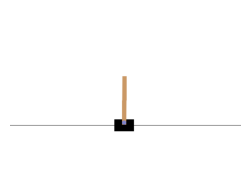

In [12]:
env_handler.render_animation(random_agent)

Now the trained model:

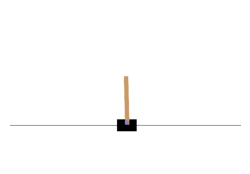

In [13]:
env_handler.render_animation(real_agent)

### Discussion of Hyperparameter Search
Note, that while we have found suitable hyperparameters through our strategy that made all different models converge to the intended value of surviving for at least 200 steps, there are multiple comments to be made:
* We have largely tuned the hyper-parameters for all models jointly. This might be a good first-order approximation, but of course we could achieve faster and more stable convergence by following a more precise tuning.
* For instance, adding a *target network* or *double q-function* to the Q-Learner, address the overestimation problem. In turn, these models could likely support larger values for the discount factor $\gamma$.
* Frequent drops in agent performance during training indicate that the learning rate had been to high at this point in time. More elaborate learning rate scheduling would likely mitigate this.
* The exploration-exploitation tradeoff is address through $\varepsilon$ and its decay. However, currently we implemented a constant decay irrespective of how much the agent's performance improved. Using an adaptive system or something more evolved like *entropy regularisation* (like in e.g. *soft-actor critic* models) would likely stabilize and speed up convergence.

Since this was intended as a learning exercise, we refrain from diving to deep into parameter tuning. Let us instead compare how the different models perform.


## Model Comparison
Now that all different algorithms converge, we should compare them. That is we want to find out how fast and stable they converge to a solution compared to each other. A good metric to compare how the models perform after each epoch, is to train all four models $n=10$ times. After each training-epoch we then let the model control the cart-pole for $m=40$ episodes and count how many actions each of these episodes lasted.

After this, for each of the four models and each training epoch, we are left with $n \cdot m$ numbers representing the distribution of how long the episodes lasted. We can combine this into a single median and additionally add 30%- and 70%-quantiles as uncertainty measures. Note, however, that this combines two averaging processes: One over the $n$ independently trained agents and another over the $m$ episodes we ran after a given epoch for each competing model. (The data is generated by running `compare_models.py`. Here we just load the results.)

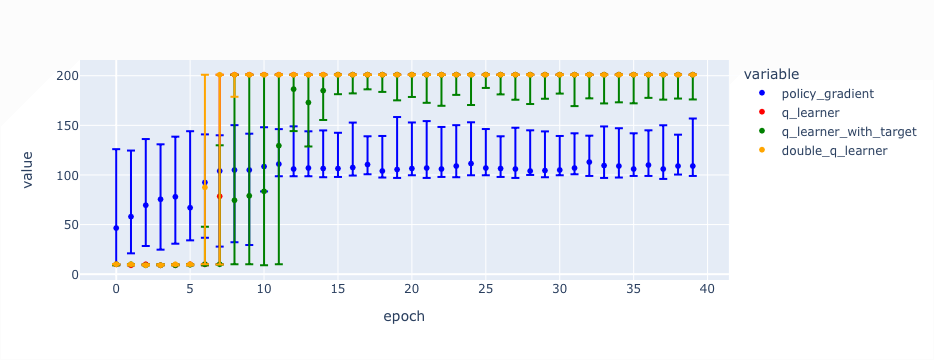

In [18]:
def make_combined_model_epoch_df(
    c_dict: dict[tuple[str, int, int], list[int]]
) -> dict[tuple[str, int], list[int]]:
    aggregated_dict = {}
    for (agent, run_id, epoch), results in c_dict.items():
        aggregated_dict[(agent, epoch)] = aggregated_dict.get((agent, epoch), []) + results
    
    tuples = [(agent, epoch, np.array(results)) for (agent, epoch), results in aggregated_dict.items()]
    df = pd.DataFrame(tuples, columns=["agent", "epoch", "results"])
    pt = pd.pivot_table(df, values="results", index="epoch", columns="agent")
    med = pt.map(np.median)
    q_upper = pt.map(lambda x: np.quantile(x, 0.7))
    q_lower = pt.map(lambda x: np.quantile(x, 0.3))
    df = pd.concat({'median': med, 'upper': q_upper, 'lower': q_lower}, names=['quantile'])
    return df


def get_scatter_plot(df: pd.DataFrame, model_name: str, marker_color: str):
    return px.scatter(
        df[model_name].loc["median"],
        error_y=df[model_name].loc["upper"]-df[model_name].loc["median"],
        error_y_minus=df[model_name].loc["median"]-df[model_name].loc["lower"],
        color_discrete_sequence=[marker_color]
    )


with open(os.path.join("pkls_and_logs", "model_comparison") + ".pkl", "rb") as file:
    model_comparison_data = pickle.load(file)

df = make_combined_model_epoch_df(model_comparison_data)
fig = get_scatter_plot(df, "policy_gradient", "blue")
fig.add_trace(get_scatter_plot(df, "q_learner", "red").data[0])
fig.add_trace(get_scatter_plot(df, "q_learner_with_target", "green").data[0])
fig.add_trace(get_scatter_plot(df, "double_q_learner", "orange").data[0])
fig.show()

### Discussion
It is instructive to see that even though all of the models converge, there are visible differences in how fast they converge as well as how consistently they converge. While, these results should be considered with some precaution due to the fact that there is still room for more and more extensive model-specific hyper-parameter tuning. The following observations can be made:
* The Policy Gradient models converge least consistenly.
* The Double Q-Learner converges by far in the most consistent way and additionally very fast.
* It is in particular interesting to see the comparison with the Q-Learner with a target network as it displays some of the same behaviour but in a much less pronounced form.